### Preparation

In [1]:
import os
import numpy as np
import sys
import torch
import torchvision
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

exp = "exp01" 
dataset_name = "cifar10"
attack_method = "badnet"
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159]) # Normalize!!
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'
cifar10_labels = { 0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

cuda


In [2]:
os.chdir(repo_dir)
print(os.getcwd())
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
import forest
print(forest.__file__)

In [3]:
manip_idx = np.load(f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/poison_info/manip_idx.npy')
manip_idx.shape

(500,)

In [4]:
poison_data_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/data'
patched_images_tensor = torch.load(os.path.join(poison_data_path, 'patched_images.pt'))
patched_labels_tensor = torch.load(os.path.join(poison_data_path, 'patched_labels.pt'))

/tmp/ipykernel_645001/369262962.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbl_tensors = torch.tensor(patched_labels_tensor)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


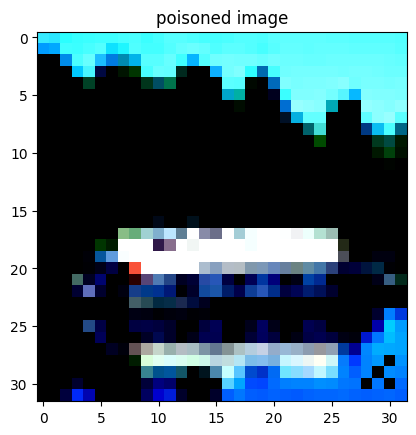

In [5]:
normalized_train_imgs = [normalize(img) for img in patched_images_tensor]
img_tensors = torch.stack(normalized_train_imgs)  
lbl_tensors = torch.tensor(patched_labels_tensor) 
patched_dataset = TensorDataset(img_tensors, lbl_tensors)
bs = 1 
poisoned_trainloader = torch.utils.data.DataLoader(patched_dataset, batch_size=bs, shuffle=False)

plt.imshow(patched_dataset[manip_idx[1]][0].permute(1, 2, 0))
plt.title('poisoned image')
plt.show()

### Frequency Analysis

In [6]:
class FreqCNN(torch.nn.Module):
    def __init__(self, image_shape):
        """
            image_shape: [c, h, w]
        """
        super(FreqCNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(image_shape[0], 32, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.elu1 = torch.nn.ELU()

        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.elu2 = torch.nn.ELU()

        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout1 = torch.nn.Dropout2d(p=0.2)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.elu3 = torch.nn.ELU()

        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.elu4 = torch.nn.ELU()

        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout2 = torch.nn.Dropout2d(p=0.3)

        self.conv5 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(128)
        self.elu5 = torch.nn.ELU()

        self.conv6 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = torch.nn.BatchNorm2d(128)
        self.elu6 = torch.nn.ELU()

        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout3 = torch.nn.Dropout2d(p=0.4)

        self.flatten = torch.nn.Flatten()

        # TODO: Make this adjust to image size...
        self.fc1 = torch.nn.Linear((image_shape[1] // 2 // 2 // 2) * (image_shape[2] // 2 // 2 // 2) * 128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu2(x)

        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu4(x)

        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.elu5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.elu6(x)

        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [7]:
from scipy.fftpack import dct, idct
def dct2(block):
    # Copied from:
    #   https://github.com/YiZeng623/frequency-backdoor/blob/main/Sec4_Frequency_Detection/Train_Detection.ipynb
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

In [8]:
# load if you have already saved the trained detector
detector = FreqCNN((3, 32, 32)).to(device)

detector.load_state_dict(torch.load(f'{repo_dir}/helpers/frequency_detector/freq_detector.pth'))
detection_thresh = 0.5

def get_indices_for_thresh_from_loader(thresh, train_loader, freq_model):
    freq_model.eval()
    identified_indices = []
    with torch.inference_mode():
        idx = 0 
        for i, (image, label) in enumerate(train_loader):     
            image = image.cpu().numpy()
            num_images = image.shape[0]
            channels = image.shape[1]  # NCHW required
            for n in range(num_images):
                for c in range(channels):
                    image[n, c, :, :] = dct2(image[n, c, :, :])

            image = torch.tensor(image, device=device)
            outputs = freq_model(image)
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            probs = outputs[:, 1][0] # keep batch size == 1!!
            if probs.cpu() >= thresh:
                identified_indices.append(idx)
            
            idx += 1
    return torch.tensor(identified_indices)

identified_indices = get_indices_for_thresh_from_loader(detection_thresh, poisoned_trainloader, detector)
detected_indices = identified_indices
print(f"In total, frequency analysis returns {len(detected_indices)} poisons")

In total, frequency analysis returns 4537 poisons


In [9]:
manip_idx_arr = np.array(manip_idx)
# How many true positives hit:
set1 = set(detected_indices.tolist())
set2 = set(manip_idx_arr.tolist())

common_elements = set1.intersection(set2)
common_tensor = torch.tensor(list(common_elements))

print(f" The algorithm returns {len(set1)} poisons...\n")
print(f" among them {len(common_tensor)} are true poisons (there're {len(manip_idx)} poisons in total -> [{(len(common_tensor)/(len(manip_idx)/100)):.2f}%] detected) \n\n their indices: {common_tensor.tolist()}\n")
print(f" the other {len(set1) - len(common_tensor)} are actually cleans...")

 The algorithm returns 4537 poisons...

 among them 376 are true poisons (there're 500 poisons in total -> [75.20%] detected) 

 their indices: [40963, 38927, 6160, 8214, 40983, 10268, 49182, 49195, 8250, 4159, 49220, 10317, 8278, 30807, 14427, 26720, 18546, 20594, 10354, 20604, 43136, 37002, 30860, 14497, 2212, 49321, 10416, 22712, 4287, 8384, 12481, 39106, 193, 4298, 22736, 35036, 2272, 30948, 22758, 8429, 24821, 14581, 18691, 20739, 35078, 22791, 12557, 47373, 45327, 39191, 2333, 47395, 26923, 28985, 6459, 4412, 31037, 16716, 43350, 2395, 8544, 45447, 43400, 49553, 31121, 29075, 18840, 49571, 43432, 39336, 45486, 27061, 31170, 35266, 33225, 459, 18892, 31188, 33240, 8665, 2523, 12772, 8678, 14826, 25072, 37362, 29175, 20984, 49657, 47610, 39424, 27153, 10775, 49697, 35361, 21028, 39462, 2603, 39468, 35374, 49712, 10810, 574, 12866, 41555, 596, 31327, 2663, 14969, 33410, 21123, 29316, 31362, 47746, 6788, 19081, 39563, 29328, 25238, 39577, 43674, 10906, 27293, 47780, 15015, 47784, 273

In [10]:
# save the detected indices
detected_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/detected/freq_detected_indices.npy'
np.save(detected_save_dir, detected_indices)